<a href="https://colab.research.google.com/github/raamav/Sentiment-Analysis-UserReviews/blob/master/IMDB_Reviews_DeepLearning_(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Reviews

**IMDB Reviews** is one of the best known datasets for sentiment analysis. It comprises a set of 50,000 highly polarized reviews of movies which are tagged with *positive* and *negative* sentiment labels.

The 50,000 reviews are categorized into training and test sets (25,000 reviews each). These reviews are full-length and some of them are several paragraphs long.

I've worked on this dataset previously and have got a validation accuracy of 80%.

**In this attempt, the objective is to get an accuracy of 85% or better.**

In [2]:
# STANDARD IMPORTS

import tensorflow as tf
from tensorflow import keras
import numpy as np


tf.__version__


'2.2.0-rc3'

In [3]:
import tensorflow_datasets as tfds

imdb,info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEJI5A9/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEJI5A9/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEJI5A9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_data = imdb['train']
test_data = imdb['test']


In [5]:
print(type(train_data))

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [0]:
# GETTING FEATURES AND LABELS FOR TRAINING AND TEST DATASETS

X_train_l = [] # sentences
y_train_l = [] # sentiment 

X_test_l = []
y_test_l = []

for s,l in train_data:
  X_train_l.append(str(s.numpy()))
  y_train_l.append(l.numpy())


for s,l in test_data:
  X_test_l.append(str(s.numpy()))
  y_test_l.append(l.numpy())



In [7]:
# DATATYPES AND SIZES OF THE DATASETS


print('/n Training Data and Label, Type {} : {}' .format(type(X_train_l) , type(y_train_l)))
print('/n Training Data and Label, Sizes {} : {}' .format(len(X_train_l) , len(y_train_l)))

/n Training Data and Label, Type <class 'list'> : <class 'list'>
/n Training Data and Label, Sizes 25000 : 25000


In [0]:
# CONVERTING EVERYTHING TO NUMPY ARRAYS
# MAJOR RELIEF POINT AS ITS TRICKY WORKING WITH TENSORS

import numpy as np

X_train = np.array(X_train_l)
y_train = np.array(y_train_l)

X_test = np.array(X_test_l)
y_test = np.array(y_test_l)

In [9]:
print('/n Training Data and Label, Type {} : {}' .format(type(X_train) , type(y_train)))
print('/n Training Data and Label, Sizes {} : {}' .format((X_train.shape) , (y_train.shape)))

/n Training Data and Label, Type <class 'numpy.ndarray'> : <class 'numpy.ndarray'>
/n Training Data and Label, Sizes (25000,) : (25000,)


### Exploratory Analysis on the Text Reviews



In [0]:
# HOW LONG ARE THE REVIEWS, TYPCALLY (WORDCOUNT)

import pandas as pd

X_train_copy = X_train.copy() # copy of the training set for exploratory work

X_train_pd = pd.DataFrame(data = X_train_copy, columns = ["review_text"])

# LANBDA FUNCTION TO CALCULATE APPROXIMATE WORD COUNT

X_train_pd['word_count'] = X_train_pd.apply(lambda x: (x['review_text'].count (' ') + 1),axis=1)

In [11]:
X_train_pd.head()

,review_text,word_count
0,"b""This was an absolutely terrible movie. Don't...",116
1,b'I have been known to fall asleep during film...,112
2,b'Mann photographs the Alberta Rocky Mountains...,132
3,b'This is the kind of film for a snowy Sunday ...,88
4,"b'As others have mentioned, all the women that...",81


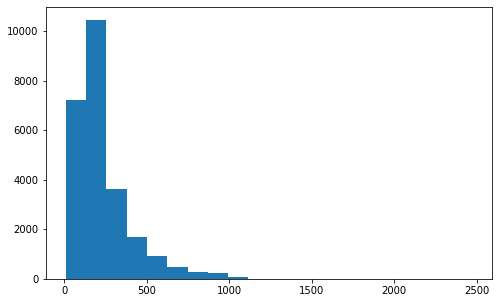

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,5))
plt.hist(X_train_pd['word_count'], bins = 20)
plt.show()

In [13]:
# DISTRIBUTION OF word_count VARIABLE TO UNDERSTAND THE OPTIMAL LENGTH OF REVIEW
X_train_pd['word_count'].describe()

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word_count, dtype: float64

N_words = 175 seems like a good optimal choice for the review length


### Basic Text Preproessing

Entails 
1. Converting text to lower case, 
2. Removing punctuations/numeric fields, 
3. Addressing contrctions *(e.g. won't -> will not)* 

In [14]:
! pip install contractions
import contractions

     |████████████████████████████████| 317kB 11.7MB/s 
     |████████████████████████████████| 245kB 26.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81691 sha256=aaa3221dd2a4e1e3756ec8cfc53fd902e12e09d06760c40c4a9b88032aef1ca9
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
# FUNCTION TO IMPLEMENT BASIC TEXT PREPROCESSING : LOWER-CASING & REMOVING NUMBERS/PUNCTUATION



def basic_preprocessor(text):
  
  import re
  import string
  import contractions
  

  # EXPANDING OUT CONTRACTIONS
  # e.g : don't -> do not
  text = contractions.fix(text)

  # TEXT TO LOWERCASE
  text = text.lower()

    
  # The syntax of re.sub() is:: re.sub(pattern, replace, source_string)
    
  # CODE TO HANDLE POSSESSIVES ('s) 
  # e.g: movie's -> movie s
  # THE HOPE IS THAT LSTMs SHOULD BE ABLE TO PROCESS "s" 
  text = re.sub(r"(\w+)'s", r'\1 s', text)
  
  # HANDLING OTHER PUNCTUATION
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
    
  return text

In [0]:
# TESTING FUNCTION

X_train_pd['review_text_mod'] = X_train_pd.apply(lambda x: basic_preprocessor(x['review_text']),axis=1)

In [17]:
print(X_train_pd['review_text'][0])

print("\n")

print(X_train_pd['review_text_mod'][0])


b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


bthis was an absolutely terrible movie do not be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie s ridiculous storyline this movie is an early nineties us p

(Additionally, will remove stop-words if needed)

In [18]:
# TEST SET
X_test_pd = pd.DataFrame(data = X_test, columns = ["review_text"])
X_test_pd['review_text_mod'] = X_test_pd.apply(lambda x: basic_preprocessor(x['review_text']),axis=1)


# CHECKING IF TE TRANSFORMATIONS WORKED OUT AS DESIGNED
print(X_test_pd['review_text'][0])
print("\n")
print(X_test_pd['review_text_mod'][0])

b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."


bthere are films that make careers for george romero it

In [0]:
# CREATING THE TEST AND TRAINING SETSSET
X_train_pd = X_train_pd[['review_text_mod']].copy()
X_test_pd = X_test_pd[['review_text_mod']].copy()

In [20]:
# EXAMINING BOTH THE TRAINING AND TEST SETS
X_train_pd.head()


,review_text_mod
0,bthis was an absolutely terrible movie do not ...
1,bi have been known to fall asleep during films...
2,bmann photographs the alberta rocky mountains ...
3,bthis is the kind of film for a snowy sunday a...
4,bas others have mentioned all the women that g...


We now have the pre-processed analytical data-set

<BR>

## Building Consolidated Vocabulary for the Document

Storing the vocabulary in the `master_vocab` dictionary

In [0]:
# CALCULATING WORD FREQUENCY IN THE CORPUS
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [22]:
# IMPLEMENTING WORD FREQUENCY FUNCTION, STORING RESULTS IN master_vocab VARIABLE

sentences = X_train_pd["review_text_mod"].progress_apply(lambda x: x.split()).values
master_vocab = build_vocab(sentences)

100%|██████████| 25000/25000 [00:01<00:00, 23389.22it/s]


In [23]:
# PRINTING OUT THE TOP K ENTRIES
print({k: master_vocab[k] for k in list(master_vocab)[:20]})

# TOP 50 WORDS
print("\n")
sorted(master_vocab, key = lambda x: (-master_vocab[x], x))[0:50]


{'bthis': 3593, 'was': 49110, 'an': 21268, 'absolutely': 1453, 'terrible': 1567, 'movie': 41927, 'do': 12763, 'not': 45531, 'be': 26613, 'lured': 28, 'in': 91800, 'by': 22224, 'christopher': 387, 'walken': 127, 'or': 17561, 'michael': 1229, 'ironside': 25, 'both': 3325, 'are': 33491, 'great': 8824}




['the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'that',
 'this',
 'was',
 'as',
 'not',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'are',
 'on',
 'you',
 'have',
 'his',
 'he',
 'be',
 'one',
 'at',
 'all',
 'they',
 'by',
 'an',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'its',
 'has',
 'out',
 'there',
 'some',
 'if',
 'would',
 'what',
 'good',
 'more']

In [24]:
len(master_vocab)

137702

## Tokenizing (and Padding) Text 


In [0]:
# SPECIFYING HYPERPARAMETERS

vocab_size = 10000
embedding_dim = 20
max_length = 175  
trunc_type = 'post'
oov_tok = "<OOV>"


In [26]:
# IMPORTING LIBRARIES AND SETTING-UP TOKENIZER

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# IMPLEMENTING TOKENIZER

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

tokenizer.fit_on_texts(X_train_pd['review_text_mod'])


In [28]:
# EXPLORING THE WORD-INDEX

word_index = tokenizer.word_index
print("length of the unfiltered vocabulary : ", len(word_index))

print("Type of object", type(word_index))



length of the unfiltered vocabulary :  137703
Type of object <class 'dict'>


In [29]:
# PADDING SEQUENCES - TRAINING SET

X_train_seq = tokenizer.texts_to_sequences(X_train_pd['review_text_mod'])

print("length of the first training sequence: ",len(X_train_seq[0])) # This is aligned with the length of the first sentence
      
X_train_pad = pad_sequences(X_train_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_train_pad[0])) # Should be 175



length of the first training sequence:  120
length of the first training sequence (PADDED):  175


In [30]:
# TOKENIZATION AND PADDING ON TEST DATA

X_test_seq = tokenizer.texts_to_sequences(X_test_pd['review_text_mod'])

print("length of the first test sequence: ",len(X_test_seq[0])) # This is aligned with the length of the first sentence
      
X_test_pad = pad_sequences(X_test_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_test_pad[0])) # Should be 175


length of the first test sequence:  163
length of the first training sequence (PADDED):  175


In [31]:
print(type(X_train_pad))
print(X_train_pad.shape)

print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(25000, 175)
<class 'numpy.ndarray'>
(25000,)


We now have the encoded and padded, training and test sets `X_train_pad` and `X_test_pad`.

<BR>

## LSTM Based Model

In [32]:
# DIVIDING THE TEST SET INTO VALIDATION AND TEST SETS

print(X_test_pad.shape)

X_val_pad = X_test_pad[0:12500]
X_test_pad = X_test_pad[12500:]

y_val = y_test[0:12500]
y_test = y_test[12500:]


(25000, 175)


In [33]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS

#vocab_size = vocab_size   # NUMBER OF UNIQUE WORDS IN VOCAB = 10,000 
#embedding_dim = embedding_dim
sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 175


lstm_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embedding_dim,
                                         input_length = sentence_length),
                          
                  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True)),
                  #keras.layers.LayerNormalization(),
                  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
                  #keras.layers.LayerNormalization(),
                  keras.layers.Bidirectional(keras.layers.LSTM(32)),


                  #keras.layers.GlobalAveragePooling1D(),

                  keras.layers.Dense(128, activation = "relu"),
                  keras.layers.Dropout(rate = 0.1),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.1),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 175, 20)           200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 175, 256)          152576    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 175, 128)          164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [34]:
# QUICK CHECK ON DATA-TYPES AND SHAPES

print(type(X_train_pad),X_train_pad.shape )
print(type(y_train),y_train.shape)

print('\n')

print(type(X_test_pad),X_test_pad.shape )
print(type(y_test),y_test.shape)


<class 'numpy.ndarray'> (25000, 175)
<class 'numpy.ndarray'> (25000,)


<class 'numpy.ndarray'> (12500, 175)
<class 'numpy.ndarray'> (12500,)


In [35]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("imdb_lstm_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_1 = lstm_model.fit(X_train_pad,y_train, epochs = 20,
                            validation_data = (X_val_pad, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
782/782 [==============================] - 44s 57ms/step - loss: 0.4883 - accuracy: 0.7632 - val_loss: 0.4874 - val_accuracy: 0.8339
Epoch 2/20
782/782 [==============================] - 43s 55ms/step - loss: 0.3205 - accuracy: 0.8649 - val_loss: 0.3687 - val_accuracy: 0.8418
Epoch 3/20
782/782 [==============================] - 43s 55ms/step - loss: 0.2550 - accuracy: 0.8993 - val_loss: 0.4141 - val_accuracy: 0.8348
Epoch 4/20
782/782 [==============================] - 43s 55ms/step - loss: 0.2124 - accuracy: 0.9162 - val_loss: 0.4326 - val_accuracy: 0.8255
Epoch 5/20
782/782 [==============================] - 43s 55ms/step - loss: 0.1630 - accuracy: 0.9393 - val_loss: 0.8203 - val_accuracy: 0.7939
Epoch 6/20
782/782 [==============================] - 43s 55ms/step - loss: 0.1301 - accuracy: 0.9524 - val_loss: 0.4681 - val_accuracy: 0.8154


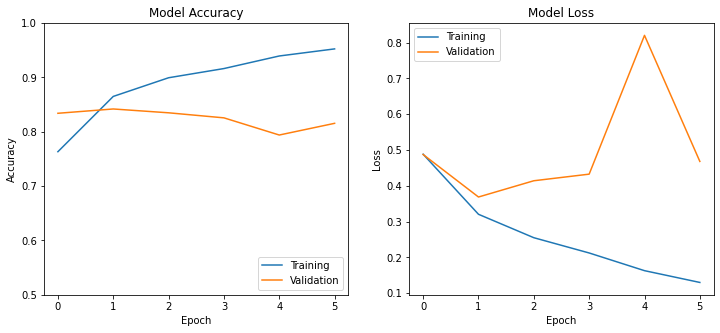

In [36]:
history = history_1


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')


In [37]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('imdb_lstm_best.h5')

best_model.evaluate(X_test_pad, y_test)

391/391 [==============================] - 7s 18ms/step - loss: 0.3702 - accuracy: 0.8381


[0.37022340297698975, 0.8380799889564514]

In [0]:
# BLANK CELL

## Using Pre-trained Embeddings to Clean-up Data

In [39]:
# IMPORTING THE EMBEDDINGS
# AUTHOR: LAURENCE MORONEY, AI ADVOCATE AT GOOGLE 

# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};

with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

--2020-04-18 19:09:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   136MB/s    in 2.4s    

2020-04-18 19:09:31 (136 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [40]:
# PRINT OUT THE LENGTH OF THE DICTIONARY

print("len(embeddings_index)",len(embeddings_index))

# VIEW ONE ITEM FROM THE DICTIONARY

#print("\n representation of a single word", take(1, embeddings_index.items()))

len(embeddings_index) 400000


The above is interesting and provides a lot of perspective

In [0]:
# DEFINING FUNCTION CHECK OVERLAP BETWEEN master_vocab AND embeddings_index
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [42]:
# IMPLEMENTING THE FUCNTION

oov = check_coverage(master_vocab,embeddings_index)

100%|██████████| 137702/137702 [00:00<00:00, 777929.00it/s]

Found embeddings for 43.89% of vocab
Found embeddings for  97.78% of all text


In [43]:
# A QUICK LOOK AT THE TOP 45 OOV WORDS

oov[0:45]

[('bthis', 3593),
 ('bthe', 1664),
 ('youve', 387),
 ('bwhen', 320),
 ('bwhat', 309),
 ('werent', 291),
 ('bthere', 281),
 ('lowbudget', 271),
 ('bafter', 208),
 ('bfirst', 204),
 ('overthetop', 199),
 ('bwell', 195),
 ('shouldnt', 189),
 ('bmovie', 183),
 ('moviethe', 163),
 ('itthe', 161),
 ('writerdirector', 155),
 ('bfor', 151),
 ('hadnt', 150),
 ('filmthe', 146),
 ('theyve', 142),
 ('oneliners', 142),
 ('moviei', 136),
 ('reallife', 125),
 ('mustsee', 125),
 ('wouldve', 120),
 ('byou', 110),
 ('balthough', 108),
 ('couldve', 107),
 ('bwow', 104),
 ('bwhile', 103),
 ('bjust', 101),
 ('madefortv', 95),
 ('bhow', 95),
 ('bnot', 95),
 ('bive', 94),
 ('onedimensional', 94),
 ('bokay', 90),
 ('middleaged', 80),
 ('bhaving', 79),
 ('yearold', 73),
 ('bwith', 73),
 ('wellwritten', 72),
 ('thoughtprovoking', 72),
 ('bwhy', 67)]

In [0]:
# DEFINE A MIS-SPELLING DICTIONARY

mispell_dict = {
  'bthis': 'this',
 'bthe': 'the',
 'youve': 'you have',
 'bwhen': 'when',
 'bwhat': 'bwhat',
 'werent': 'were not',
 'bthere': 'there',
 'lowbudget': 'low budget',
 'bafter': 'after',
 'bfirst': 'first',
 'overthetop': 'over the top',
 'bwell': 'well',
 'shouldnt': 'should not',
 'bmovie': 'movie',
 'moviethe': 'movie the',
 'itthe': 'it the',
 'writerdirector': 'writer director',
 'bfor': 'for',
 'hadnt': 'hadn not',
 'filmthe': 'film the',
 'theyve': 'they have',
 'oneliners': 'one liners',
 'moviei': 'movie i',
 'reallife': 'real life',
 'mustsee': 'must see',
 'wouldve': 'would have',
 'byou': 'you',
 'balthough': 'although',
 'couldve': 'could have',
 'bwow': 'wow',
 'bwhile': 'while',
 'bjust': 'just',
 'madefortv': 'made for tv',
 'bhow': 'how',
 'bnot': 'not',
 'bive': 'i have',
 'onedimensional': 'one dimensional',
 'bokay': 'okay',
 'middleaged': 'middle aged',
 'bhaving': 'having',
 'yearold': 'year old',
 'bwith': 'with',
 'wellwritten': 'well written',
 'thoughtprovoking': 'thought provoking',
 'bwhy': 'why'

}





In [0]:
# TESTING
#mispell_dict = {'shouldnt': 'should not'}

In [0]:
# WRITING A FUNCTION TO CLEAN THE ABOVE INCONSISTENCIES
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings


import re

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispellings, mispellings_re = _get_mispell(mispell_dict)



def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [0]:
# TESTING

# sample = "she shouldnt have left"

# sample = replace_typical_misspell(sample)

# print(sample)

# X_train_pd = X_train_pd[['review_text_mod']].copy()
# X_test_pd = X_test_pd[['review_text_mod']].copy()

In [48]:
# IMPLEMENTING THE FUNCTION FOR TRAINING AND TEST SETS

X_train_pd["review_text_mod2"] = X_train_pd["review_text_mod"].progress_apply(lambda x: replace_typical_misspell(x))
X_test_pd["review_text_mod2"] = X_test_pd["review_text_mod"].progress_apply(lambda x: replace_typical_misspell(x))


100%|██████████| 25000/25000 [00:02<00:00, 9540.26it/s]


In [0]:
# CHECKING THE IMPLEMENTATION OF THE FUNCTION

#X_train_pd.head(2)

In [0]:
X_train_pd2 = X_train_pd[['review_text_mod2']].copy()
X_test_pd2 = X_test_pd[['review_text_mod2']].copy()

In [51]:
X_train_pd2.head(2)

,review_text_mod2
0,this was an absolutely terrible movie do not b...
1,bi have been known to fall asleep during films...


In [52]:
# RE-TOKENIZATING TEST
# RE-TOKENIZATING TEST


# IMPLEMENTING TOKENIZER

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

tokenizer.fit_on_texts(X_train_pd2['review_text_mod2'])


# EXPLORING THE WORD-INDEX

word_index2 = tokenizer.word_index
print("\n length of the unfiltered vocabulary : ", len(word_index2))

print("Type of object", type(word_index2))


# PADDING SEQUENCES - TRAINING SET

X_train_seq2 = tokenizer.texts_to_sequences(X_train_pd2['review_text_mod2'])

print("\n length of the first training sequence: ",len(X_train_seq2[0])) # This is aligned with the length of the first sentence
      
X_train_pad2 = pad_sequences(X_train_seq2, maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_train_pad2[0])) # Should be 175


# TOKENIZATION AND PADDING ON TEST DATA

X_test_seq2 = tokenizer.texts_to_sequences(X_test_pd2['review_text_mod2'])

print("\n length of the first test sequence: ",len(X_test_seq2[0])) # This is aligned with the length of the first sentence
      
X_test_pad2 = pad_sequences(X_test_seq2, maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_test_pad2[0])) # Should be 175



 length of the unfiltered vocabulary :  137522
Type of object <class 'dict'>

 length of the first training sequence:  120
length of the first training sequence (PADDED):  175

 length of the first test sequence:  165
length of the first training sequence (PADDED):  175


In [53]:
print(type(X_train_pad2))
print(X_train_pad2.shape)

print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(25000, 175)
<class 'numpy.ndarray'>
(25000,)


In [54]:
# DIVIDING THE TEST SET INTO VALIDATION AND TEST SETS

print(X_test_pad2.shape)

X_val_pad2 = X_test_pad2[0:12500]
X_test_pad2 = X_test_pad2[12500:]



(25000, 175)


In [55]:
# RE-IMPLEMENTING THE PREVIOUSLY SPECIFIED MODEL ON CLEANED UP DATA

# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("imdb_lstm_best_2.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_2 = lstm_model.fit(X_train_pad2,y_train, epochs = 20,
                            validation_data = (X_val_pad2, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
782/782 [==============================] - 45s 57ms/step - loss: 0.4813 - accuracy: 0.7756 - val_loss: 0.3864 - val_accuracy: 0.8364
Epoch 2/20
782/782 [==============================] - 44s 56ms/step - loss: 0.3058 - accuracy: 0.8744 - val_loss: 0.3834 - val_accuracy: 0.8420
Epoch 3/20
782/782 [==============================] - 44s 56ms/step - loss: 0.2373 - accuracy: 0.9076 - val_loss: 0.4104 - val_accuracy: 0.8384
Epoch 4/20
782/782 [==============================] - 43s 55ms/step - loss: 0.1920 - accuracy: 0.9283 - val_loss: 0.5302 - val_accuracy: 0.8108
Epoch 5/20
782/782 [==============================] - 43s 56ms/step - loss: 0.1515 - accuracy: 0.9450 - val_loss: 0.5655 - val_accuracy: 0.8211
Epoch 6/20
782/782 [==============================] - 43s 54ms/step - loss: 0.1115 - accuracy: 0.9619 - val_loss: 0.6122 - val_accuracy: 0.8222


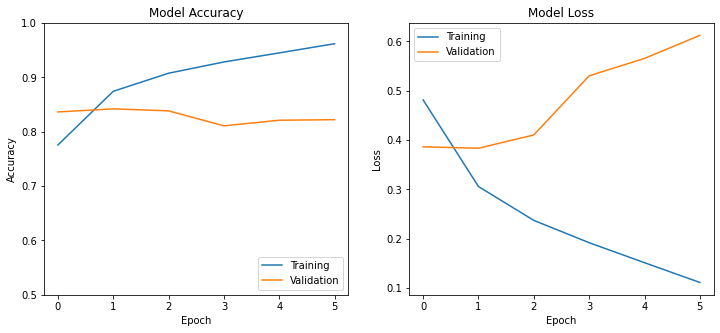

In [56]:
history = history_2


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')


In [57]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('imdb_lstm_best_2.h5')

best_model.evaluate(X_test_pad2, y_test)

391/391 [==============================] - 7s 18ms/step - loss: 0.3883 - accuracy: 0.8378


[0.3883105516433716, 0.8378400206565857]

In [0]:
# BLANK

## LSTM Model with Pre-trained Embeddings 

In [59]:
# COVERTING THE embedding_index TO embedding_matrix
# NOTE: embedding_index is derived fro external embeddings
# AN IMPORTANT PIECE OF CODE
# AUTHOR: https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings 

# HYPERPARAMETERS
max_features = vocab_size
word_index = word_index


# CODE
all_embs = np.stack(embeddings_index.values())

emb_mean,emb_std = all_embs.mean(), all_embs.std()

embed_size = all_embs.shape[1]

nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
#inp = Input(shape=(maxlen,))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [60]:
print("\n embed_size = ",embed_size)


 embed_size =  100


In [0]:
# INTENTIONALLY LEFT BLANK

In [0]:
# INTENTIONALLY LEFT BLANK

In [0]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS

#vocab_size = vocab_size   # NUMBER OF UNIQUE WORDS IN VOCAB = 10,000 
#embedding_dim = embedding_dim
sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 175


lstm_emb_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embed_size,
                                         input_length = sentence_length,
                                         weights=[embedding_matrix], trainable= True),
                          
                  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True, recurrent_dropout = 0.1, dropout = 0.1)),
                  #keras.layers.LayerNormalization(),
                  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences = True, recurrent_dropout= 0.1, dropout = 0.1)),
                  #keras.layers.LayerNormalization(),
                  keras.layers.Bidirectional(keras.layers.LSTM(64)),


                  #keras.layers.GlobalAveragePooling1D(),

                  keras.layers.Dense(128, activation = "relu"),
                  keras.layers.Dropout(rate = 0.1),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.1),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
lstm_emb_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 175, 100)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 175, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 175, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [0]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("imdb_lstm_emb_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_emb_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_3 = lstm_emb_model.fit(X_train_pad2,y_train, epochs = 20,
                            validation_data = (X_val_pad2, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
782/782 [==============================] - 1986s 3s/step - loss: 0.7232 - accuracy: 0.5288 - val_loss: 0.8640 - val_accuracy: 0.5537
Epoch 2/20
782/782 [==============================] - 1957s 3s/step - loss: 0.4565 - accuracy: 0.7797 - val_loss: 0.4415 - val_accuracy: 0.7665
Epoch 3/20
782/782 [==============================] - 1940s 2s/step - loss: 0.2868 - accuracy: 0.8836 - val_loss: 0.3804 - val_accuracy: 0.8457
Epoch 4/20
782/782 [==============================] - 1980s 3s/step - loss: 0.2289 - accuracy: 0.9122 - val_loss: 0.4195 - val_accuracy: 0.8386
Epoch 5/20
782/782 [==============================] - 1993s 3s/step - loss: 0.1854 - accuracy: 0.9333 - val_loss: 0.4303 - val_accuracy: 0.8346
Epoch 6/20
782/782 [==============================] - 2027s 3s/step - loss: 0.1513 - accuracy: 0.9470 - val_loss: 0.4813 - val_accuracy: 0.8194
Epoch 7/20
782/782 [==============================] - 2068s 3s/step - loss: 0.1210 - accuracy: 0.9602 - val_loss: 0.5372 - val_accuracy:

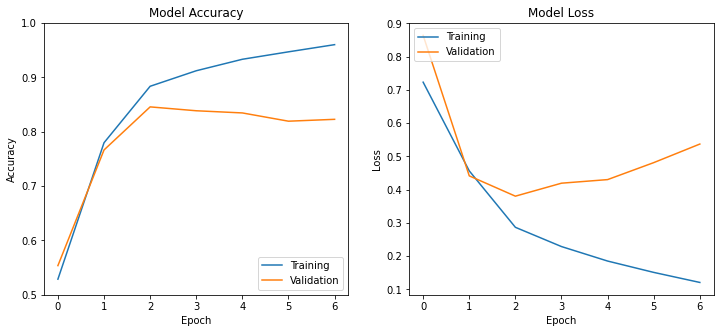

In [0]:
history = history_3


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')


In [0]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('imdb_lstm_emb_best.h5')

best_model.evaluate(X_test_pad2, y_test)

391/391 [==============================] - 70s 180ms/step - loss: 0.3834 - accuracy: 0.8426


[0.3834415376186371, 0.8426399827003479]

In [0]:
# INTENTIONALLY LEFT BLANK

In [0]:
# INTENTIONALLY LEFT BLANK

## Exploring BERT -  a Transformer Based Architecture 

In late 2018, Google (open-sourced)[https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html] BERT and heralded a revolution in NLP.

BERT stands for Bidirectional Encoder Representations from Transformers. It is a pre-trained architecture that has been trained on a on a HUGE corpus of unlabeled text (including the entire Wikipedia and the Book Corpus)  

In [62]:
! pip install transformers

     |████████████████████████████████| 573kB 9.8MB/s 
     |████████████████████████████████| 1.0MB 54.4MB/s 
     |████████████████████████████████| 890kB 42.6MB/s 
     |████████████████████████████████| 3.7MB 50.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=eca2af8be99a14794a343118f5927bc70658ba8914c0aad6051f8e3a8f580930
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [63]:
from transformers import (TFBertForSequenceClassification, 
                          BertTokenizer,
                          TFRobertaForSequenceClassification, 
                          RobertaTokenizer)

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-cased")

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

To recollect, `X_train_pd2` and `X_test_pd2` are the pre-tokenized versions of the data sets

In [74]:
type(train_data)

tf.__version__

'2.2.0-rc3'

In [79]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("bert_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)


# COMPILE AND FIT MODEL

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


bert_model.compile(optimizer="adam", loss= loss, metrics=['accuracy'])
 
history_4 = bert_model.fit(X_train,y_train, epochs = 20,
                            validation_data = (X_val_pad2, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            )

Epoch 1/20
782/782 [==============================] - 592s 757ms/step - loss: 0.7220 - accuracy: 0.5010 - val_loss: 0.6937 - val_accuracy: 0.5033
Epoch 2/20
 59/782 [=>............................] - ETA: 7:36 - loss: 0.7189 - accuracy: 0.5064

KeyboardInterrupt: ignored

In [0]:
history = history_4


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')

In [0]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('bert_best.h5')

best_model.evaluate(X_test_pad2, y_test)